# Overview

This Colab helps to create and validate a training set for the k-NN classifier described in the MediaPipe [Pose Classification](https://google.github.io/mediapipe/solutions/pose_classification.html) soultion, test it on an arbitrary video, export to a CSV and then use it in the [ML Kit sample app](https://developers.google.com/ml-kit/vision/pose-detection/classifying-poses#4_integrate_with_the_ml_kit_quickstart_app).

# Step 0: Start Colab

Connect the Colab to hosted Python3 runtime (check top-right corner) and then install required dependencies.

In [ ]:
!pip install pillow
!pip install matplotlib
!pip install numpy
!pip install opencv-python
!pip install tqdm
!pip install requests

!pip install mediapipe

# Codebase

## Commons

In [ ]:
from matplotlib import pyplot as plt


def show_image(img, figsize=(10, 10)):
  """Shows output PIL image."""
  plt.figure(figsize=figsize)
  plt.imshow(img)
  plt.show()

## Pose embedding

In [ ]:
class FullBodyPoseEmbedder(object):
  """Converts 3D pose landmarks into 3D embedding."""

  def __init__(self, torso_size_multiplier=2.5):
    # Multiplier to apply to the torso to get minimal body size.
    self._torso_size_multiplier = torso_size_multiplier

    # Names of the landmarks as they appear in the prediction.
    self._landmark_names = [
        'nose',
        'left_eye_inner', 'left_eye', 'left_eye_outer',
        'right_eye_inner', 'right_eye', 'right_eye_outer',
        'left_ear', 'right_ear',
        'mouth_left', 'mouth_right',
        'left_shoulder', 'right_shoulder',
        'left_elbow', 'right_elbow',
        'left_wrist', 'right_wrist',
        'left_pinky_1', 'right_pinky_1',
        'left_index_1', 'right_index_1',
        'left_thumb_2', 'right_thumb_2',
        'left_hip', 'right_hip',
        'left_knee', 'right_knee',
        'left_ankle', 'right_ankle',
        'left_heel', 'right_heel',
        'left_foot_index', 'right_foot_index',
    ]

  def __call__(self, landmarks):
    assert landmarks.shape[0] == len(self._landmark_names), \
        f'Unexpected number of landmarks: {landmarks.shape[0]}'

    landmarks = np.copy(landmarks)

    # Normalize landmarks.
    landmarks = self._normalize_pose_landmarks(landmarks)

    # Base embedding from pairwise distances.
    embedding = self._get_pose_distance_embedding(landmarks)

    # --- CUSTOM FEATURES ---

    # 1. Left elbow angle (shoulder–elbow–wrist)
    left_shoulder = landmarks[self._landmark_names.index('left_shoulder')]
    left_elbow = landmarks[self._landmark_names.index('left_elbow')]
    left_wrist = landmarks[self._landmark_names.index('left_wrist')]
    left_elbow_angle = self._compute_angle(left_shoulder, left_elbow, left_wrist)

    # 2. Distance from left wrist to left shoulder
    hand_shoulder_dist = np.linalg.norm(left_wrist - left_shoulder)

    # 3. Distance between feet (left_foot_index and right_foot_index)
    left_foot = landmarks[self._landmark_names.index('left_foot_index')]
    right_foot = landmarks[self._landmark_names.index('right_foot_index')]
    feet_dist = np.linalg.norm(left_foot - right_foot)

    
    # Append these custom features to the embedding
    embedding = np.concatenate([
        embedding.flatten(),                  # original distances (N, 3) → flat
        [left_elbow_angle,                    # scalar
         hand_shoulder_dist,                  # scalar
         feet_dist]                           # scalar
    ])
    
    embedding = np.array(list(embedding) + [left_elbow_angle, hand_shoulder_dist, feet_dist])
    


    return embedding


  def _normalize_pose_landmarks(self, landmarks):
    """Normalizes landmarks translation and scale."""
    landmarks = np.copy(landmarks)

    # Normalize translation.
    pose_center = self._get_pose_center(landmarks)
    landmarks -= pose_center

    # Normalize scale.
    pose_size = self._get_pose_size(landmarks, self._torso_size_multiplier)
    landmarks /= pose_size
    # Multiplication by 100 is not required, but makes it eaasier to debug.
    landmarks *= 100

    return landmarks

  def _get_pose_center(self, landmarks):
    """Calculates pose center as point between hips."""
    left_hip = landmarks[self._landmark_names.index('left_hip')]
    right_hip = landmarks[self._landmark_names.index('right_hip')]
    center = (left_hip + right_hip) * 0.5
    return center

  def _get_pose_size(self, landmarks, torso_size_multiplier):
    """Calculates pose size.

    It is the maximum of two values:
      * Torso size multiplied by `torso_size_multiplier`
      * Maximum distance from pose center to any pose landmark
    """
    # This approach uses only 2D landmarks to compute pose size.
    landmarks = landmarks[:, :2]

    # Hips center.
    left_hip = landmarks[self._landmark_names.index('left_hip')]
    right_hip = landmarks[self._landmark_names.index('right_hip')]
    hips = (left_hip + right_hip) * 0.5

    # Shoulders center.
    left_shoulder = landmarks[self._landmark_names.index('left_shoulder')]
    right_shoulder = landmarks[self._landmark_names.index('right_shoulder')]
    shoulders = (left_shoulder + right_shoulder) * 0.5

    # Torso size as the minimum body size.
    torso_size = np.linalg.norm(shoulders - hips)

    # Max dist to pose center.
    pose_center = self._get_pose_center(landmarks)
    max_dist = np.max(np.linalg.norm(landmarks - pose_center, axis=1))

    return max(torso_size * torso_size_multiplier, max_dist)

  def _get_pose_distance_embedding(self, landmarks):
    """Converts pose landmarks into 3D embedding.

    We use several pairwise 3D distances to form pose embedding. All distances
    include X and Y components with sign. We differnt types of pairs to cover
    different pose classes. Feel free to remove some or add new.

    Args:
      landmarks - NumPy array with 3D landmarks of shape (N, 3).

    Result:
      Numpy array with pose embedding of shape (M, 3) where `M` is the number of
      pairwise distances.
    """
    embedding = np.array([
        # One joint.

        self._get_distance(
            self._get_average_by_names(landmarks, 'left_hip', 'right_hip'),
            self._get_average_by_names(landmarks, 'left_shoulder', 'right_shoulder')),

        self._get_distance_by_names(landmarks, 'left_shoulder', 'left_elbow'),
        self._get_distance_by_names(landmarks, 'right_shoulder', 'right_elbow'),

        self._get_distance_by_names(landmarks, 'left_elbow', 'left_wrist'),
        self._get_distance_by_names(landmarks, 'right_elbow', 'right_wrist'),

        self._get_distance_by_names(landmarks, 'left_hip', 'left_knee'),
        self._get_distance_by_names(landmarks, 'right_hip', 'right_knee'),

        self._get_distance_by_names(landmarks, 'left_knee', 'left_ankle'),
        self._get_distance_by_names(landmarks, 'right_knee', 'right_ankle'),

        # Two joints.

        self._get_distance_by_names(landmarks, 'left_shoulder', 'left_wrist'),
        self._get_distance_by_names(landmarks, 'right_shoulder', 'right_wrist'),

        self._get_distance_by_names(landmarks, 'left_hip', 'left_ankle'),
        self._get_distance_by_names(landmarks, 'right_hip', 'right_ankle'),

        # Four joints.

        self._get_distance_by_names(landmarks, 'left_hip', 'left_wrist'),
        self._get_distance_by_names(landmarks, 'right_hip', 'right_wrist'),

        # Five joints.

        self._get_distance_by_names(landmarks, 'left_shoulder', 'left_ankle'),
        self._get_distance_by_names(landmarks, 'right_shoulder', 'right_ankle'),

        self._get_distance_by_names(landmarks, 'left_hip', 'left_wrist'),
        self._get_distance_by_names(landmarks, 'right_hip', 'right_wrist'),

        # Cross body.

        self._get_distance_by_names(landmarks, 'left_elbow', 'right_elbow'),
        self._get_distance_by_names(landmarks, 'left_knee', 'right_knee'),

        self._get_distance_by_names(landmarks, 'left_wrist', 'right_wrist'),
        self._get_distance_by_names(landmarks, 'left_ankle', 'right_ankle'),

        # Body bent direction.

        # self._get_distance(
        #     self._get_average_by_names(landmarks, 'left_wrist', 'left_ankle'),
        #     landmarks[self._landmark_names.index('left_hip')]),
        # self._get_distance(
        #     self._get_average_by_names(landmarks, 'right_wrist', 'right_ankle'),
        #     landmarks[self._landmark_names.index('right_hip')]),
    ])

    return embedding

  def _get_average_by_names(self, landmarks, name_from, name_to):
    lmk_from = landmarks[self._landmark_names.index(name_from)]
    lmk_to = landmarks[self._landmark_names.index(name_to)]
    return (lmk_from + lmk_to) * 0.5

  def _get_distance_by_names(self, landmarks, name_from, name_to):
    lmk_from = landmarks[self._landmark_names.index(name_from)]
    lmk_to = landmarks[self._landmark_names.index(name_to)]
    return self._get_distance(lmk_from, lmk_to)

  def _get_distance(self, lmk_from, lmk_to):
    return lmk_to - lmk_from

  def _compute_angle(self, a, b, c):
    """Computes angle ABC (in degrees) where B is the vertex."""
    ba = a - b
    bc = c - b
    cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc) + 1e-6)
    angle = np.arccos(np.clip(cosine_angle, -1.0, 1.0))
    return np.degrees(angle)

In [ ]:
class PlayerSwingEmbedding(object):
    
    def __init__(self, stance_land, load_land, landing_land, contact_land, follow_land):
        self.stance_landmarks = stance_land
        self.load_landmarks = load_land
        self.landing_landmarks = landing_land
        self.contact_landmarks = contact_land
        self.follow_landmarks = follow_land
       
        
        
        self._landmark_names = [
        'nose',
        'left_eye_inner', 'left_eye', 'left_eye_outer',
        'right_eye_inner', 'right_eye', 'right_eye_outer',
        'left_ear', 'right_ear',
        'mouth_left', 'mouth_right',
        'left_shoulder', 'right_shoulder',
        'left_elbow', 'right_elbow',
        'left_wrist', 'right_wrist',
        'left_pinky_1', 'right_pinky_1',
        'left_index_1', 'right_index_1',
        'left_thumb_2', 'right_thumb_2',
        'left_hip', 'right_hip',
        'left_knee', 'right_knee',
        'left_ankle', 'right_ankle',
        'left_heel', 'right_heel',
        'left_foot_index', 'right_foot_index',
    ]

    def __call__(self, landmarks):
        # 
        embedding = np.array([self.stance_landmarks, self.load_landmarks, self.landing_landmarks, self.contact_landmarks, self.follow_landmarks])
        
        # Body Proportion Stats
        torso_leg_rat = None
        
        arm_length = None
        wrist_elbow_dist = None
        pelv_rot_angle = None
        feet_dist = None
        upper_flex_ang = None
        knee_flex = None
        head_torso_rat = None
        trunk_arm_len = None
        hand_shoulder_dist = None
        
        return
    
    def _torso_to_leg():
        """
        Calculates the Torso-To-Leg 
        Ratio Of a Given Player
        """
        
        # torso length
        torso_left = _compute_distance(
                     self.stance_landmarks
                                      )
    
    def _compute_distance(x1, y1, z1, x2, y2, z2):
        return np.sqrt((x2 - x1)**2 + (y2 - y1)**2 + (z2 - z1)**2)
    
    
        

    

## Pose classification

In [ ]:
class PoseSample(object):

  def __init__(self, name, landmarks, class_name, embedding):
    self.name = name
    self.landmarks = landmarks
    self.class_name = class_name

    self.embedding = embedding


class PoseSampleOutlier(object):

  def __init__(self, sample, detected_class, all_classes):
    self.sample = sample
    self.detected_class = detected_class
    self.all_classes = all_classes

In [ ]:
import csv
import numpy as np
import os

import numpy as np

class PoseClassifier(object):
  def __init__(self,
               pose_samples_folder,
               pose_embedder,
               file_extension='csv',
               file_separator=',',
               n_landmarks=33,
               n_dimensions=3,
               top_n_by_max_distance=30,
               top_n_by_mean_distance=10,
               axes_weights=None):  # ← change default
               
    self._pose_embedder = pose_embedder
    self._n_landmarks = n_landmarks
    self._n_dimensions = n_dimensions
    self._top_n_by_max_distance = top_n_by_max_distance
    self._top_n_by_mean_distance = top_n_by_mean_distance

    # Compute default axes weights if not provided
    if axes_weights is None:
      base_embedding_len = 24 * 3        # 24 pairwise distances × 3 (x, y, z)
      extra_features_len = 3             # angle + 2 scalar distances
      self._axes_weights = np.array(
        ([1.0, 1.0, 0.2] * 24) + [1.0] * extra_features_len,
         dtype=np.float32
    )

    else:
      self._axes_weights = np.array(axes_weights, dtype=np.float32)

    self._pose_samples = self._load_pose_samples(pose_samples_folder,
                                                 file_extension,
                                                 file_separator,
                                                 n_landmarks,
                                                 n_dimensions,
                                                 pose_embedder)


  def _load_pose_samples(self,
                         pose_samples_folder,
                         file_extension,
                         file_separator,
                         n_landmarks,
                         n_dimensions,
                         pose_embedder):
    """Loads pose samples from a given folder.

    Required folder structure:
      neutral_standing.csv
      pushups_down.csv
      pushups_up.csv
      squats_down.csv
      ...

    Required CSV structure:
      sample_00001,x1,y1,z1,x2,y2,z2,....
      sample_00002,x1,y1,z1,x2,y2,z2,....
      ...
    """
    # Each file in the folder represents one pose class.
    file_names = [name for name in os.listdir(pose_samples_folder) if name.endswith(file_extension)]

    pose_samples = []
    for file_name in file_names:
      # Use file name as pose class name.
      class_name = file_name[:-(len(file_extension) + 1)]

      # Parse CSV.
      with open(os.path.join(pose_samples_folder, file_name)) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=file_separator)
        for row in csv_reader:
          expected_embedding_len = 75  # or use: pose_embedder(np.zeros((33, 3))).shape[0] to get it dynamically
          assert len(row) == expected_embedding_len + 1, f'Wrong number of values: {len(row)}'

          
          embedding = np.array(row[1:], dtype=np.float32)
          pose_samples.append(PoseSample(
              name=row[0],
              landmarks=None,
              class_name=class_name,
              embedding=embedding,
          ))

    return pose_samples

  def find_pose_sample_outliers(self):
    """Classifies each sample against the entire database."""
    # Find outliers in target poses
    outliers = []
    for sample in self._pose_samples:
      # Find nearest poses for the target one.
      pose_landmarks = sample.landmarks.copy()
      pose_classification = self.__call__(pose_landmarks)
      class_names = [class_name for class_name, count in pose_classification.items() if count == max(pose_classification.values())]

      # Sample is an outlier if nearest poses have different class or more than
      # one pose class is detected as nearest.
      if sample.class_name not in class_names or len(class_names) != 1:
        outliers.append(PoseSampleOutlier(sample, class_names, pose_classification))

    return outliers

  def __call__(self, pose_landmarks):
    """Classifies given pose.

    Classification is done in two stages:
      * First we pick top-N samples by MAX distance. It allows to remove samples
        that are almost the same as given pose, but has few joints bent in the
        other direction.
      * Then we pick top-N samples by MEAN distance. After outliers are removed
        on a previous step, we can pick samples that are closes on average.

    Args:
      pose_landmarks: NumPy array with 3D landmarks of shape (N, 3).

    Returns:
      Dictionary with count of nearest pose samples from the database. Sample:
        {
          'pushups_down': 8,
          'pushups_up': 2,
        }
    """
    # Check that provided and target poses have the same shape.
    assert pose_landmarks.shape == (self._n_landmarks, self._n_dimensions), 'Unexpected shape: {}'.format(pose_landmarks.shape)

    # Get given pose embedding.
    pose_embedding = self._pose_embedder(pose_landmarks)
    flipped_pose_embedding = self._pose_embedder(pose_landmarks * np.array([-1, 1, 1]))
    

    # Filter by max distance.
    #
    # That helps to remove outliers - poses that are almost the same as the
    # given one, but has one joint bent into another direction and actually
    # represnt a different pose class.
    max_dist_heap = []
    for sample_idx, sample in enumerate(self._pose_samples):
      max_dist = min(
          np.max(np.abs(sample.embedding - pose_embedding) * self._axes_weights),
          np.max(np.abs(sample.embedding - flipped_pose_embedding) * self._axes_weights),
      )
      max_dist_heap.append([max_dist, sample_idx])

    max_dist_heap = sorted(max_dist_heap, key=lambda x: x[0])
    max_dist_heap = max_dist_heap[:self._top_n_by_max_distance]

    # Filter by mean distance.
    #
    # After removing outliers we can find the nearest pose by mean distance.
    mean_dist_heap = []
    for _, sample_idx in max_dist_heap:
      sample = self._pose_samples[sample_idx]
      mean_dist = min(
          np.mean(np.abs(sample.embedding - pose_embedding) * self._axes_weights),
          np.mean(np.abs(sample.embedding - flipped_pose_embedding) * self._axes_weights),
      )
      mean_dist_heap.append([mean_dist, sample_idx])

    mean_dist_heap = sorted(mean_dist_heap, key=lambda x: x[0])
    mean_dist_heap = mean_dist_heap[:self._top_n_by_mean_distance]

    # Collect results into map: (class_name -> n_samples)
    class_names = [self._pose_samples[sample_idx].class_name for _, sample_idx in mean_dist_heap]
    result = {class_name: class_names.count(class_name) for class_name in set(class_names)}

    return result

## Classification smoothing

In [ ]:
class EMADictSmoothing(object):
  """Smoothes pose classification."""

  def __init__(self, window_size=10, alpha=0.2):
    self._window_size = window_size
    self._alpha = alpha

    self._data_in_window = []

  def __call__(self, data):
    """Smoothes given pose classification.

    Smoothing is done by computing Exponential Moving Average for every pose
    class observed in the given time window. Missed pose classes arre replaced
    with 0.

    Args:
      data: Dictionary with pose classification. Sample:
          {
            'pushups_down': 8,
            'pushups_up': 2,
          }

    Result:
      Dictionary in the same format but with smoothed and float instead of
      integer values. Sample:
        {
          'pushups_down': 8.3,
          'pushups_up': 1.7,
        }
    """
    # Add new data to the beginning of the window for simpler code.
    self._data_in_window.insert(0, data)
    self._data_in_window = self._data_in_window[:self._window_size]

    # Get all keys.
    keys = set([key for data in self._data_in_window for key, _ in data.items()])

    # Get smoothed values.
    smoothed_data = dict()
    for key in keys:
      factor = 1.0
      top_sum = 0.0
      bottom_sum = 0.0
      for data in self._data_in_window:
        value = data[key] if key in data else 0.0

        top_sum += factor * value
        bottom_sum += factor

        # Update factor.
        factor *= (1.0 - self._alpha)

      smoothed_data[key] = top_sum / bottom_sum

    return smoothed_data

## Repetition counter

In [ ]:
class RepetitionCounter(object):
  """Counts number of repetitions of given target pose class."""

  def __init__(self, class_name, enter_threshold=6, exit_threshold=4):
    self._class_name = class_name

    # If pose counter passes given threshold, then we enter the pose.
    self._enter_threshold = enter_threshold
    self._exit_threshold = exit_threshold

    # Either we are in given pose or not.
    self._pose_entered = False

    # Number of times we exited the pose.
    self._n_repeats = 0

  @property
  def n_repeats(self):
    return self._n_repeats

  def __call__(self, pose_classification):
    """Counts number of repetitions happend until given frame.

    We use two thresholds. First you need to go above the higher one to enter
    the pose, and then you need to go below the lower one to exit it. Difference
    between the thresholds makes it stable to prediction jittering (which will
    cause wrong counts in case of having only one threshold).

    Args:
      pose_classification: Pose classification dictionary on current frame.
        Sample:
          {
            'pushups_down': 8.3,
            'pushups_up': 1.7,
          }

    Returns:
      Integer counter of repetitions.
    """
    # Get pose confidence.
    pose_confidence = 0.0
    if self._class_name in pose_classification:
      pose_confidence = pose_classification[self._class_name]

    # On the very first frame or if we were out of the pose, just check if we
    # entered it on this frame and update the state.
    if not self._pose_entered:
      self._pose_entered = pose_confidence > self._enter_threshold
      return self._n_repeats

    # If we were in the pose and are exiting it, then increase the counter and
    # update the state.
    if pose_confidence < self._exit_threshold:
      self._n_repeats += 1
      self._pose_entered = False

    return self._n_repeats

## Classification visualizer

In [ ]:
import io
from PIL import Image
from PIL import ImageFont
from PIL import ImageDraw
import requests

class PoseClassificationVisualizer(object):
  """Keeps track of claassifcations for every frame and renders them."""

  def __init__(self,
               class_name,
               plot_location_x=0.05,
               plot_location_y=0.05,
               plot_max_width=0.4,
               plot_max_height=0.4,
               plot_figsize=(9, 4),
               plot_x_max=None,
               plot_y_max=None,
               counter_location_x=0.5,
               counter_location_y=0.05,
               counter_font_path='https://github.com/googlefonts/roboto/blob/main/src/hinted/Roboto-Regular.ttf?raw=true',
               counter_font_color='red',
               counter_font_size=0.05):
    self._class_name = class_name
    self._plot_location_x = plot_location_x
    self._plot_location_y = plot_location_y
    self._plot_max_width = plot_max_width
    self._plot_max_height = plot_max_height
    self._plot_figsize = plot_figsize
    self._plot_x_max = plot_x_max
    self._plot_y_max = plot_y_max
    self._counter_location_x = counter_location_x
    self._counter_location_y = counter_location_y
    self._counter_font_path = counter_font_path
    self._counter_font_color = counter_font_color
    self._counter_font_size = counter_font_size

    self._counter_font = None

    # self._pose_classification_history = []
    # self._pose_classification_filtered_history = []

  def __call__(self,
               frame,
               pose_classification,
               pose_classification_filtered,
               repetitions_count):
    """Renders pose classifcation and counter until given frame."""
    # Extend classification history.
    # self._pose_classification_history.append(pose_classification)
    # self._pose_classification_filtered_history.append(pose_classification_filtered)

    # Output frame with classification plot and counter.
    output_img = Image.fromarray(frame)

    output_width = output_img.size[0]
    output_height = output_img.size[1]

    # # Draw the plot.
    # img = self._plot_classification_history(output_width, output_height)
    # img.thumbnail((int(output_width * self._plot_max_width),
    #                int(output_height * self._plot_max_height)),
    #               Image.ANTIALIAS)
    # output_img.paste(img,
    #                  (int(output_width * self._plot_location_x),
    #                   int(output_height * self._plot_location_y)))

    # Draw the count.
    output_img_draw = ImageDraw.Draw(output_img)
    if self._counter_font is None:
      font_size = int(output_height * self._counter_font_size)
      font_request = requests.get(self._counter_font_path, allow_redirects=True)
      self._counter_font = ImageFont.truetype(io.BytesIO(font_request.content), size=font_size)
    output_img_draw.text((output_width * self._counter_location_x,
                          output_height * self._counter_location_y),
                         str(repetitions_count),
                         font=self._counter_font,
                         fill=self._counter_font_color)

    return output_img

  # def _plot_classification_history(self, output_width, output_height):
  #   fig = plt.figure(figsize=self._plot_figsize)

  #   for classification_history in [self._pose_classification_history,
  #                                  self._pose_classification_filtered_history]:
  #     y = []
  #     for classification in classification_history:
  #       if classification is None:
  #         y.append(None)
  #       elif self._class_name in classification:
  #         y.append(classification[self._class_name])
  #       else:
  #         y.append(0)
  #     plt.plot(y, linewidth=7)

  #   plt.grid(axis='y', alpha=0.75)
  #   plt.xlabel('Frame')
  #   plt.ylabel('Confidence')
  #   plt.title('Classification history for `{}`'.format(self._class_name))
  #   plt.legend(loc='upper right')

  #   if self._plot_y_max is not None:
  #     plt.ylim(top=self._plot_y_max)
  #   if self._plot_x_max is not None:
  #     plt.xlim(right=self._plot_x_max)

  #   # Convert plot to image.
  #   buf = io.BytesIO()
  #   dpi = min(
  #       output_width * self._plot_max_width / float(self._plot_figsize[0]),
  #       output_height * self._plot_max_height / float(self._plot_figsize[1]))
  #   fig.savefig(buf, dpi=dpi)
  #   buf.seek(0)
  #   img = Image.open(buf)
  #   plt.close()

  #   return img

In [ ]:
def _compute_angle(a, b, c):
        
        ba = np.array([a[0] - b[0], a[1] - b[1]])
        bc = np.array([c[0] - b[0], c[1] - b[1]])
        cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
        angle = np.arccos(np.clip(cosine_angle, -1.0, 1.0))
        
        return np.degrees(angle)

In [ ]:
def _compute_distance(left_knee, right_knee):
        dx = left_knee[0] - right_knee[0]
        dy = left_knee[1] - right_knee[1]
        dz = left_knee[2] - right_knee[2]
        
        return np.sqrt(dx**2 + dy**2 + dz**2)

## Bootstrap helper

In [ ]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import os
from PIL import Image
import sys
import tqdm
import csv

from mediapipe.python.solutions import drawing_utils as mp_drawing
from mediapipe.python.solutions import pose as mp_pose


class BootstrapHelper(object):
  """Helps to bootstrap images and filter pose samples for classification."""

  def __init__(self,
               images_in_folder,
               images_out_folder,
               csvs_out_folder,
               pose_embedder):
    self._images_in_folder = images_in_folder
    self._images_out_folder = images_out_folder
    self._csvs_out_folder = csvs_out_folder
    self._pose_embedder = pose_embedder

    # Get list of pose classes and print image statistics.
    self._pose_class_names = sorted([n for n in os.listdir(self._images_in_folder) if not n.startswith('.')])

  def bootstrap(self, per_pose_class_limit=None):
    """Bootstraps images in a given folder.

    Required image in folder (same use for image out folder):
      pushups_up/
        image_001.jpg
        image_002.jpg
        ...
      pushups_down/
        image_001.jpg
        image_002.jpg
        ...
      ...

    Produced CSVs out folder:
      pushups_up.csv
      pushups_down.csv

    Produced CSV structure with pose 3D landmarks:
      sample_00001,x1,y1,z1,x2,y2,z2,....
      sample_00002,x1,y1,z1,x2,y2,z2,....
    """
    # Create output folder for CVSs.
    if not os.path.exists(self._csvs_out_folder):
      os.makedirs(self._csvs_out_folder)

    for pose_class_name in self._pose_class_names:
      print('Bootstrapping ', pose_class_name, file=sys.stderr)

      # Paths for the pose class.
      images_in_folder = os.path.join(self._images_in_folder, pose_class_name)
      images_out_folder = os.path.join(self._images_out_folder, pose_class_name)
      csv_out_path = os.path.join(self._csvs_out_folder, pose_class_name + '.csv')
      if not os.path.exists(images_out_folder):
        os.makedirs(images_out_folder)

      with open(csv_out_path, 'w') as csv_out_file:
        csv_out_writer = csv.writer(csv_out_file, delimiter=',', quoting=csv.QUOTE_MINIMAL)
        # Get list of images.
        image_names = sorted([n for n in os.listdir(images_in_folder) if not n.startswith('.')])
        if per_pose_class_limit is not None:
          image_names = image_names[:per_pose_class_limit]

        # Bootstrap every image.
        for image_name in tqdm.tqdm(image_names):
          # Load image.
          input_frame = cv2.imread(os.path.join(images_in_folder, image_name))
          if input_frame is None:
            print(f"Error: Could not load image {image_name}")
            continue  # Skip to the next image or handle the error appropriately.
          input_frame = cv2.cvtColor(input_frame, cv2.COLOR_BGR2RGB)
          
          

          # Initialize fresh pose tracker and run it.
          with mp_pose.Pose(static_image_mode=True,
                       min_detection_confidence=0.3,
                       min_tracking_confidence=0.3) as pose_tracker:
            result = pose_tracker.process(image=input_frame)
            pose_landmarks = result.pose_landmarks

          # Save image with pose prediction (if pose was detected).
          output_frame = input_frame.copy()
          if pose_landmarks is not None:
            mp_drawing.draw_landmarks(
                image=output_frame,
                landmark_list=pose_landmarks,
                connections=mp_pose.POSE_CONNECTIONS)
          output_frame = cv2.cvtColor(output_frame, cv2.COLOR_RGB2BGR)
          cv2.imwrite(os.path.join(images_out_folder, image_name), output_frame)

          # Save landmarks if pose was detected.
          if pose_landmarks is not None:
            # Get landmarks.
            frame_height, frame_width = output_frame.shape[0], output_frame.shape[1]
            pose_landmarks = np.array(
                [[lmk.x * frame_width, lmk.y * frame_height, lmk.z * frame_width]
                 for lmk in pose_landmarks.landmark],
                dtype=np.float32)
            assert pose_landmarks.shape == (33, 3), 'Unexpected landmarks shape: {}'.format(pose_landmarks.shape)
            
             
            
            left_elbow_angle = _compute_angle(pose_landmarks[11], pose_landmarks[13], pose_landmarks[15])
            hand_shoulder_dist = _compute_distance(pose_landmarks[19], pose_landmarks[11])
            feet_dist = _compute_distance(pose_landmarks[31], pose_landmarks[32])
            
            embedding = self._pose_embedder(pose_landmarks)
            csv_out_writer.writerow([image_name] + embedding.astype(str).tolist())



          # Draw XZ projection and concatenate with the image.
          projection_xz = self._draw_xz_projection(
              output_frame=output_frame, pose_landmarks=pose_landmarks)
          output_frame = np.concatenate((output_frame, projection_xz), axis=1)

  def _draw_xz_projection(self, output_frame, pose_landmarks, r=0.5, color='red'):
    frame_height, frame_width = output_frame.shape[0], output_frame.shape[1]
    img = Image.new('RGB', (frame_width, frame_height), color='white')

    if pose_landmarks is None:
      return np.asarray(img)

    # Scale radius according to the image width.
    r *= frame_width * 0.01

    draw = ImageDraw.Draw(img)
    for idx_1, idx_2 in mp_pose.POSE_CONNECTIONS:
      # Flip Z and move hips center to the center of the image.
      x1, y1, z1 = pose_landmarks[idx_1] * [1, 1, -1] + [0, 0, frame_height * 0.5]
      x2, y2, z2 = pose_landmarks[idx_2] * [1, 1, -1] + [0, 0, frame_height * 0.5]

      draw.ellipse([x1 - r, z1 - r, x1 + r, z1 + r], fill=color)
      draw.ellipse([x2 - r, z2 - r, x2 + r, z2 + r], fill=color)
      draw.line([x1, z1, x2, z2], width=int(r), fill=color)

    return np.asarray(img)

  def align_images_and_csvs(self, print_removed_items=False):
    """Makes sure that image folders and CSVs have the same sample.

    Leaves only intersetion of samples in both image folders and CSVs.
    """
    for pose_class_name in self._pose_class_names:
      # Paths for the pose class.
      images_out_folder = os.path.join(self._images_out_folder, pose_class_name)
      csv_out_path = os.path.join(self._csvs_out_folder, pose_class_name + '.csv')

      # Read CSV into memory.
      rows = []
      with open(csv_out_path) as csv_out_file:
        csv_out_reader = csv.reader(csv_out_file, delimiter=',')
        for row in csv_out_reader:
          rows.append(row)

      # Image names left in CSV.
      image_names_in_csv = []

      # Re-write the CSV removing lines without corresponding images.
      with open(csv_out_path, 'w') as csv_out_file:
        csv_out_writer = csv.writer(csv_out_file, delimiter=',', quoting=csv.QUOTE_MINIMAL)
        for row in rows:
          image_name = row[0]
          image_path = os.path.join(images_out_folder, image_name)
          if os.path.exists(image_path):
            image_names_in_csv.append(image_name)
            csv_out_writer.writerow(row)
          elif print_removed_items:
            print('Removed image from CSV: ', image_path)

      # Remove images without corresponding line in CSV.
      for image_name in os.listdir(images_out_folder):
        if image_name not in image_names_in_csv:
          image_path = os.path.join(images_out_folder, image_name)
          os.remove(image_path)
          if print_removed_items:
            print('Removed image from folder: ', image_path)

  def analyze_outliers(self, outliers):
    """Classifies each sample agains all other to find outliers.

    If sample is classified differrrently than the original class - it sould
    either be deleted or more similar samples should be aadded.
    """
    for outlier in outliers:
      image_path = os.path.join(self._images_out_folder, outlier.sample.class_name, outlier.sample.name)

      print('Outlier')
      print('  sample path =    ', image_path)
      print('  sample class =   ', outlier.sample.class_name)
      print('  detected class = ', outlier.detected_class)
      print('  all classes =    ', outlier.all_classes)

      img = cv2.imread(image_path)
      img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
      show_image(img, figsize=(20, 20))

  def remove_outliers(self, outliers):
    """Removes outliers from the image folders."""
    for outlier in outliers:
      image_path = os.path.join(self._images_out_folder, outlier.sample.class_name, outlier.sample.name)
      os.remove(image_path)

  def print_images_in_statistics(self):
    """Prints statistics from the input image folder."""
    self._print_images_statistics(self._images_in_folder, self._pose_class_names)

  def print_images_out_statistics(self):
    """Prints statistics from the output image folder."""
    self._print_images_statistics(self._images_out_folder, self._pose_class_names)

  def _print_images_statistics(self, images_folder, pose_class_names):
    print('Number of images per pose class:')
    for pose_class_name in pose_class_names:
      n_images = len([
          n for n in os.listdir(os.path.join(images_folder, pose_class_name))
          if not n.startswith('.')])
      print('  {}: {}'.format(pose_class_name, n_images))

# Step 1: Build classifier

## Upload image samples

Locally create a folder named `fitness_poses_images_in` with image samples.

Images should repesent terminal states of desired pose classes. I.e. if you want to classify push-up provide iamges for two classes: when person is up, and when person is down.

There should be about a few hundred samples per class covering different camera angles, environment conditions, body shapes, and exercise variations to build a good classifier.

Required structure of the images_in_folder:
```
fitness_poses_images_in/
  pushups_up/
    image_001.jpg
    image_002.jpg
    ...
  pushups_down/
    image_001.jpg
    image_002.jpg
    ...
  ...
```

Zip the `fitness_poses_images_in` folder:
```
zip -r fitness_poses_images_in.zip fitness_poses_images_in
```

And run the code below to upload it to the Colab runtime

In [ ]:
from google.colab import files
import os

uploaded = files.upload()
os.listdir('.')

Unzip the archive:

In [ ]:
import zipfile
import io

zf = zipfile.ZipFile(io.BytesIO(uploaded['fitness_poses_images_in.zip']), "r")
zf.extractall()
os.listdir('.')

## Bootstrap images

In [ ]:
# Required structure of the images_in_folder:
#
#   fitness_poses_images_in/
#     pushups_up/
#       image_001.jpg
#       image_002.jpg
#       ...
#     pushups_down/
#       image_001.jpg
#       image_002.jpg
#       ...
#     ...
bootstrap_images_in_folder = '/Users/danielfonseca/repos/baseball_pose/training_data'

# Output folders for bootstrapped images and CSVs.
bootstrap_images_out_folder = '/Users/danielfonseca/repos/baseball_pose/bootstrap_out'
bootstrap_csvs_out_folder = '/Users/danielfonseca/repos/baseball_pose/csvs_out'
pose_embedder = FullBodyPoseEmbedder()

In [ ]:
# Initialize helper.
bootstrap_helper = BootstrapHelper(
    images_in_folder=bootstrap_images_in_folder,
    images_out_folder=bootstrap_images_out_folder,
    csvs_out_folder=bootstrap_csvs_out_folder,
    pose_embedder=pose_embedder
    
)

In [ ]:
# Check how many pose classes and images for them are available.
bootstrap_helper.print_images_in_statistics()

In [ ]:
# Bootstrap all images.
# Set limit to some small number for debug.
bootstrap_helper.bootstrap(per_pose_class_limit=None)

In [ ]:
# Check how many images were bootstrapped.
bootstrap_helper.print_images_out_statistics()

In [ ]:
# After initial bootstrapping images without detected poses were still saved in
# the folderd (but not in the CSVs) for debug purpose. Let's remove them.
bootstrap_helper.align_images_and_csvs(print_removed_items=False)
bootstrap_helper.print_images_out_statistics()

## Manual filtration

Please manually verify predictions and remove samples (images) that has wrong pose prediction. Check as if you were asked to classify pose just from predicted landmarks. If you can't - remove it.

Align CSVs and image folders once you are done.

In [ ]:
# Align CSVs with filtered images.
bootstrap_helper.align_images_and_csvs(print_removed_items=False)
bootstrap_helper.print_images_out_statistics()

## Automatic filtration

Classify each sample against database of all other samples and check if it gets in the same class as annotated after classification.

There can be two reasons for the outliers:

  * **Wrong pose prediction**: In this case remove such outliers.

  * **Wrong classification** (i.e. pose is predicted correctly and you aggree with original pose class assigned to the sample): In this case sample is from the underrepresented group (e.g. unusual angle or just very few samples). Add more similar samples and run bootstrapping from the very beginning.

Even if you just removed some samples it makes sence to re-run automatic filtration one more time as database of poses has changed.

**Important!!** Check that you are using the same parameters when classifying whole videos later.

In [ ]:
# Find outliers.

# Transforms pose landmarks into embedding.
pose_embedder = FullBodyPoseEmbedder()

# Classifies give pose against database of poses.
pose_classifier = PoseClassifier(
    pose_samples_folder=bootstrap_csvs_out_folder,
    pose_embedder=pose_embedder,
    top_n_by_max_distance=30,
    top_n_by_mean_distance=10)

outliers = pose_classifier.find_pose_sample_outliers()
print('Number of outliers: ', len(outliers))

In [ ]:
# Analyze outliers.
bootstrap_helper.analyze_outliers(outliers)

In [ ]:
# Remove all outliers (if you don't want to manually pick).
bootstrap_helper.remove_outliers(outliers)

In [ ]:
# Align CSVs with images after removing outliers.
bootstrap_helper.align_images_and_csvs(print_removed_items=False)
bootstrap_helper.print_images_out_statistics()

## Dump for the App

Dump filtered poses to CSV and download it.

Please check this [guide](https://developers.google.com/ml-kit/vision/pose-detection/classifying-poses#4_integrate_with_the_ml_kit_quickstart_app) on how to use this CSV in the ML Kit sample app.

In [ ]:
import csv
import os
import numpy as np


def dump_for_the_app():
  pose_samples_folder = 'fitness_poses_csvs_out'
  pose_samples_csv_path = 'fitness_poses_csvs_out.csv'
  file_extension = 'csv'
  file_separator = ','

  # Each file in the folder represents one pose class.
  file_names = [name for name in os.listdir(pose_samples_folder) if name.endswith(file_extension)]

  with open(pose_samples_csv_path, 'w') as csv_out:
    csv_out_writer = csv.writer(csv_out, delimiter=file_separator, quoting=csv.QUOTE_MINIMAL)
    for file_name in file_names:
      # Use file name as pose class name.
      class_name = file_name[:-(len(file_extension) + 1)]

      # One file line: `sample_00001,x1,y1,x2,y2,....`.
      with open(os.path.join(pose_samples_folder, file_name)) as csv_in:
        csv_in_reader = csv.reader(csv_in, delimiter=file_separator)
        for row in csv_in_reader:
          row.insert(1, class_name)
          csv_out_writer.writerow(row)

  files.download(pose_samples_csv_path)


dump_for_the_app()

# Step 2: Classification

**Important!!** Check that you are using the same classification parameters as while building classifier.

In [27]:
# Specify your video name and target pose class to count the repetitions.
names = ['betts_2']
video_path = '/Users/danielfonseca/repos/baseball_pose/vids/acuna_2.mp4'
class_name='stance'
out_video_path = '/Users/danielfonseca/repos/baseball_pose/vids/acuna_2_model_angles.mp4'

In [28]:
# Open the video.
import cv2

video_cap = cv2.VideoCapture(video_path)

# Get some video parameters to generate output video with classificaiton.
video_n_frames = video_cap.get(cv2.CAP_PROP_FRAME_COUNT)
video_fps = video_cap.get(cv2.CAP_PROP_FPS)
video_width = int(video_cap.get(cv2.CAP_PROP_FRAME_WIDTH))
video_height = int(video_cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

I0000 00:00:1745613703.143779 24503353 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1
  0%|          | 0/118.0 [00:00<?, ?it/s]W0000 00:00:1745613703.226877 24524177 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745613703.238267 24524177 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 118/118.0 [00:03<00:00, 29.67it/s]


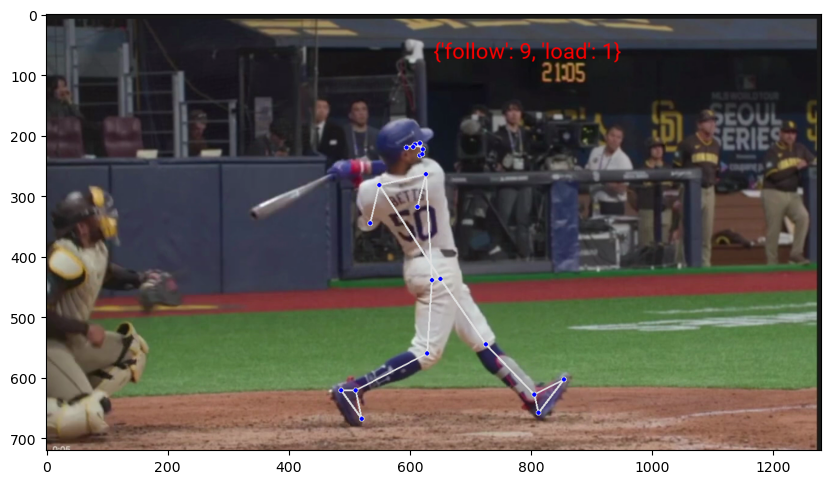

In [29]:
# Initilize tracker, classifier and counter.
# Do that before every video as all of them have state.
import cv2
from collections import defaultdict
import pandas as pd
embeddings = []
for name in names:
    video_path = f'/Users/danielfonseca/repos/baseball_pose/vids/{name}.mp4'
    class_name='stance'
    out_video_path = '/Users/danielfonseca/repos/baseball_pose/vids/acuna_2_model_angles.mp4'
    video_cap = cv2.VideoCapture(video_path)
    video_n_frames = video_cap.get(cv2.CAP_PROP_FRAME_COUNT)
    video_fps = video_cap.get(cv2.CAP_PROP_FPS)
    video_width = int(video_cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    video_height = int(video_cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    frame_classifications = run(video_cap)
    
    df = pd.DataFrame([stance_dict[0] for stance_dict in frame_classifications])
    highest_frame_scores = df.idxmax().to_dict()

    classification_data = defaultdict()
    for stance, frame in highest_frame_scores.items():
        classification_data[stance] = [frame, frame_classifications[frame][1]]
    

    embedding = PlayerSwingEmbedding(classification_data)
    embedding = embedding().tolist()
    embeddings.append([name, embedding])

In [ ]:
# Run classification on a video.
def run(video_cap):
    import os
    import tqdm
    import cv2
    import numpy as np
    from mediapipe.python.solutions import drawing_utils as mp_drawing
    
    from mediapipe.python.solutions import pose as mp_pose


    # Folder with pose class CSVs. That should be the same folder you using while
    # building classifier to output CSVs.
    pose_samples_folder = '/Users/danielfonseca/repos/baseball_pose/csvs_out'

    # Initialize tracker.
    pose_tracker = mp_pose.Pose(min_detection_confidence=0.5,
                        min_tracking_confidence=0.5)

    # Initialize embedder.
    pose_embedder = FullBodyPoseEmbedder()

    # Initialize classifier.


    # Check that you are using the same parameters as during bootstrapping.
    pose_classifier = PoseClassifier(
        pose_samples_folder=pose_samples_folder,
        pose_embedder=pose_embedder,
        top_n_by_max_distance=30,
        top_n_by_mean_distance=10)

    # # Uncomment to validate target poses used by classifier and find outliers.
    # outliers = pose_classifier.find_pose_sample_outliers()
    # print('Number of pose sample outliers (consider removing them): ', len(outliers))

    # Initialize EMA smoothing.
    pose_classification_filter = EMADictSmoothing(
        window_size=10,
        alpha=0.2)

    # Initialize counter.
    repetition_counter = RepetitionCounter(
        class_name=class_name,
        enter_threshold=6,
        exit_threshold=4)

    # Initialize renderer.
    pose_classification_visualizer = PoseClassificationVisualizer(
        class_name=class_name,
        plot_x_max=video_n_frames,
        # Graphic looks nicer if it's the same as `top_n_by_mean_distance`.
        plot_y_max=10)

    # Open output video.
    out_video = cv2.VideoWriter(out_video_path, cv2.VideoWriter_fourcc(*'mp4v'), video_fps, (video_width, video_height))

    frame_idx = 0
    output_frame = None
    frame_classifications = []
    with tqdm.tqdm(total=video_n_frames, position=0, leave=True) as pbar:
        while True:
            # Get next frame of the video.
            success, input_frame = video_cap.read()
            if not success:
                break

            # Run pose tracker.
            input_frame = cv2.cvtColor(input_frame, cv2.COLOR_BGR2RGB)
            result = pose_tracker.process(image=input_frame)
            pose_landmarks = result.pose_landmarks

            # Draw pose prediction.
            output_frame = input_frame.copy()
            if pose_landmarks is not None:
                mp_drawing.draw_landmarks(
                    image=output_frame,
                    landmark_list=pose_landmarks,
                    connections=mp_pose.POSE_CONNECTIONS)

            if pose_landmarks is not None:
                # Get landmarks.
                frame_height, frame_width = output_frame.shape[0], output_frame.shape[1]
                pose_landmarks_arr = np.array([[lmk.x * frame_width, lmk.y * frame_height, lmk.z * frame_width]
                                            for lmk in pose_landmarks.landmark], dtype=np.float32)

                
                assert pose_landmarks_arr.shape == (33, 3), 'Unexpected landmarks shape: {}'.format(pose_landmarks_arr.shape)

                # Classify the pose on the current frame.
                pose_classification = pose_classifier(pose_landmarks_arr)

                # Smooth classification using EMA.
                pose_classification_filtered = pose_classification_filter(pose_classification)
                frame_classifications.append([pose_classification_filtered, pose_landmarks_arr])
                
                # Instead of counting repetitions, we simply do not count them.
                repetitions_count = "Repetition"
            else:
                # No pose => no classification on current frame.
                pose_classification ="Heyyy"
                pose_classification_filtered = pose_classification_filter(dict())
                pose_classification_filtered = "loll"
                repetitions_count = "boootyy"

            # Draw classification overlay (without a repetition counter).
            output_frame = pose_classification_visualizer(
                frame=output_frame,
                pose_classification=pose_classification,
                pose_classification_filtered=pose_classification_filtered,
                repetitions_count=pose_classification)

            # Save the output frame.
            out_video.write(cv2.cvtColor(np.array(output_frame), cv2.COLOR_RGB2BGR))

            # Optionally, show intermediate frames to track progress.
            # if frame_idx % 50 == 0:
            #     show_image(output_frame)

            frame_idx += 1
            pbar.update()

    # Close output video.
    out_video.release()

    # Optionally, show the last frame of the video.
    if output_frame is not None:
        show_image(output_frame)
    return frame_classifications


In [ ]:
frame_classifications

In [ ]:
import pandas as pd
from collections import defaultdict

df = pd.DataFrame([stance_dict[0] for stance_dict in frame_classifications])
highest_frame_scores = df.idxmax().to_dict()

classification_data = defaultdict()
for stance, frame in highest_frame_scores.items():
    classification_data[stance] = [frame, frame_classifications[frame][1]]
    

In [ ]:
for stance, frame in highest_frame_scores.items():
    video_cap.set(cv2.CAP_PROP_POS_FRAMES, frame)
    res, frame = video_cap.read()
    cv2.imwrite(f'frame_classifications/{stance}.png', frame)

In [ ]:
# Download generated video
files.download(out_video_path)

In [ ]:
import math
class PlayerSwingEmbedding(object):
    
    def __init__(self, lmk_poses_dict):
        self.stance_landmarks = lmk_poses_dict['stance'][1]
        self.load_landmarks = lmk_poses_dict['load'][1]
        self.landing_landmarks = lmk_poses_dict['landing'][1]
        self.contact_landmarks = lmk_poses_dict['contact'][1]
        self.follow_landmarks = lmk_poses_dict['follow'][1]
       
        
        
        self._landmark_names = [
        'nose',
        'left_eye_inner', 'left_eye', 'left_eye_outer',
        'right_eye_inner', 'right_eye', 'right_eye_outer',
        'left_ear', 'right_ear',
        'mouth_left', 'mouth_right',
        'left_shoulder', 'right_shoulder',
        'left_elbow', 'right_elbow',
        'left_wrist', 'right_wrist',
        'left_pinky_1', 'right_pinky_1',
        'left_index_1', 'right_index_1',
        'left_thumb_2', 'right_thumb_2',
        'left_hip', 'right_hip',
        'left_knee', 'right_knee',
        'left_ankle', 'right_ankle',
        'left_heel', 'right_heel',
        'left_foot_index', 'right_foot_index',
    ]

    def __call__(self):

        
        # Body Proportion Stats
        torso_leg_rat = self._get_torso_to_leg()
        left_arm_length, right_arm_length = self._get_arm_length()
        left_wrist_elbow_dist, right_wrist_elbow_dist = self._get_wrist_elbow_dist()
        feet_dist = self._get_feet_dist()
        upper_flex_ang_left, upper_flex_ang_right = self._get_upper_body_flexion_angle()
        knee_flex_ang_left, knee_flex_ang_right = self._get_knee_flexion_angle()
        head_torso_rat = None
        trunk_arm_len = None
        hand_shoulder_dist = None
        pelv_rot_angle = None
        
        
        poses = [self.stance_landmarks, self.load_landmarks, self.landing_landmarks, self.contact_landmarks, self.follow_landmarks]

        pose_data = [pose_data.flatten() for pose_data in poses]
        
        # Create extra feature array for body proportions and other stats
        extra_features = np.array([torso_leg_rat, left_arm_length, right_arm_length, 
                                   left_wrist_elbow_dist, right_wrist_elbow_dist, 
                                   feet_dist, upper_flex_ang_left, upper_flex_ang_right, knee_flex_ang_left, knee_flex_ang_right]) * 150
        
        # Concatenate the pose data and extra features together
        embedding = np.concatenate(pose_data + [extra_features])
    
        return embedding
    
    def _get_torso_to_leg(self):
        """
        Calculates the Torso-To-Leg 
        Ratio Of a Given Player
        """
        
        left_shoulder = self.stance_landmarks[self._landmark_names.index('left_shoulder')]
        right_shoulder = self.stance_landmarks[self._landmark_names.index('right_shoulder')]
        hip_left = self.stance_landmarks[self._landmark_names.index('left_hip')]
        hip_right = self.stance_landmarks[self._landmark_names.index('right_hip')]
        ankle_left = self.stance_landmarks[self._landmark_names.index('left_ankle')]
        ankle_right = self.stance_landmarks[self._landmark_names.index('right_ankle')]
        # torso length

        torso_left_length = self._compute_distance(left_shoulder[0], left_shoulder[1], left_shoulder[2],
                                              hip_left[0], hip_left[1], hip_left[2])
        torso_right_length = self._compute_distance(right_shoulder[0], right_shoulder[1], right_shoulder[2],
                                              hip_right[0], hip_right[1], hip_right[2])
        
        torso_length = (torso_left_length + torso_right_length) / 2
        
        # Calculate leg lengths
        
        leg_left_length = self._compute_distance(hip_left[0], hip_left[1], hip_left[2],
                                            ankle_left[0], ankle_left[1], ankle_left[2])
        
        leg_right_length = self._compute_distance(hip_right[0], hip_right[1], hip_right[2],
                                            ankle_right[0], ankle_right[1], ankle_right[2])
        
        leg_length = (leg_left_length + leg_right_length) / 2
        
        ratio = torso_length / leg_length
        
        return ratio
    
    def _get_arm_length(self):
        shoulder_left = self.stance_landmarks[self._landmark_names.index('left_shoulder')]
        shoulder_right = self.stance_landmarks[self._landmark_names.index('right_shoulder')]
        
        elbow_left = self.stance_landmarks[self._landmark_names.index('left_elbow')]
        elbow_right = self.stance_landmarks[self._landmark_names.index('right_elbow')]
        
        wrist_right = self.stance_landmarks[self._landmark_names.index('right_wrist')]
        wrist_left = self.stance_landmarks[self._landmark_names.index('left_wrist')]
        
        
        upper_arm_left_length = self._compute_distance(shoulder_left[0], shoulder_left[1], shoulder_left[2], 
                                                elbow_left[0], elbow_left[1], elbow_left[2])
        upper_arm_right_length = self._compute_distance(shoulder_right[0], shoulder_right[1], shoulder_right[2], 
                                                    elbow_right[0], elbow_right[1], elbow_right[2])

        # Calculate the lower arm length (elbow to wrist)
        lower_arm_left_length = self._compute_distance(elbow_left[0], elbow_left[1], elbow_left[2], 
                                                    wrist_left[0], wrist_left[1], wrist_left[2])
        lower_arm_right_length = self._compute_distance(elbow_right[0], elbow_right[1], elbow_right[2], 
                                                    wrist_right[0], wrist_right[1], wrist_right[2]) 
        
        left_arm_proportion = upper_arm_left_length / lower_arm_left_length
        right_arm_proportion = upper_arm_right_length / lower_arm_right_length
        
        return left_arm_proportion, right_arm_proportion
    
    def _get_wrist_elbow_dist(self):
        elbow_left = self.stance_landmarks[self._landmark_names.index('left_elbow')]
        elbow_right = self.stance_landmarks[self._landmark_names.index('right_elbow')]
        
        wrist_right = self.stance_landmarks[self._landmark_names.index('right_wrist')]
        wrist_left = self.stance_landmarks[self._landmark_names.index('left_wrist')]
        
        left_distance = self._compute_distance(elbow_left[0], elbow_left[1], elbow_left[2], 
                                          wrist_left[0], wrist_left[1], wrist_left[2])
        
        right_distance = self._compute_distance(elbow_right[0], elbow_right[1], elbow_right[2], 
                                                    wrist_right[0], wrist_right[1], wrist_right[2]) 
        
        return left_distance, right_distance
    
    def _get_feet_dist(self):
        foot_left = self.stance_landmarks[self._landmark_names.index('left_foot_index')]
        foot_right = self.stance_landmarks[self._landmark_names.index('right_foot_index')]
        
        return self._compute_distance(foot_left[0], foot_left[1], foot_left[2],
                                 foot_right[0], foot_right[1], foot_right[2])
        
        
    def _get_upper_body_flexion_angle(self):
        """
        Calculates the upper body flexion angle for both left and right sides
        based on 2D coordinates of the shoulders and hips for both sides.
        The angle represents how much the upper body is tilted forward from the horizontal plane.
        """

        # Extract landmarks for the left and right sides
        shoulder_left = self.landing_landmarks[self._landmark_names.index('left_shoulder')]
        shoulder_right = self.landing_landmarks[self._landmark_names.index('right_shoulder')]
        hip_left = self.landing_landmarks[self._landmark_names.index('left_hip')]
        hip_right = self.landing_landmarks[self._landmark_names.index('right_hip')]

        # Calculate the left upper body flexion angle
        xh_left, yh_left = hip_left[0], hip_left[1]
        xs_left, ys_left = shoulder_left[0], shoulder_left[1]

        # Calculate the vector from hip to shoulder for the left side
        vector_left = np.array([xs_left - xh_left, ys_left - yh_left])
        horizontal_vector = np.array([1, 0])  # Horizontal vector for comparison (x-axis)

        # Calculate the angle between the left upper body vector and the horizontal plane
        angle_left = math.degrees(math.atan2(vector_left[1], vector_left[0]))  # atan2 gives the angle in radians
        if angle_left < 0:
            angle_left += 360  # Convert negative angle to positive equivalent
            
        # Calculate the right upper body flexion angle
        xh_right, yh_right = hip_right[0], hip_right[1]
        xs_right, ys_right = shoulder_right[0], shoulder_right[1]

        # Calculate the vector from hip to shoulder for the right side
        vector_right = np.array([xs_right - xh_right, ys_right - yh_right])

        # Calculate the angle between the right upper body vector and the horizontal plane
        angle_right = math.degrees(math.atan2(vector_right[1], vector_right[0]))
        if angle_right < 0:
            angle_right += 360  # Convert negative angle to positive equivalent


        return angle_left, angle_right
    
    import math

    def _get_knee_flexion_angle(self):
        """
        Calculates the knee flexion angle for both the left and right legs
        based on 2D coordinates of the hip, knee, and ankle for both sides.
        """
        
        # Extract landmarks for the left leg
        hip_left = self.load_landmarks[self._landmark_names.index('left_hip')]
        knee_left = self.load_landmarks[self._landmark_names.index('left_knee')]
        ankle_left = self.load_landmarks[self._landmark_names.index('left_ankle')]

        # Extract landmarks for the right leg
        hip_right = self.load_landmarks[self._landmark_names.index('right_hip')]
        knee_right = self.load_landmarks[self._landmark_names.index('right_knee')]
        ankle_right = self.load_landmarks[self._landmark_names.index('right_ankle')]
        
        # Calculate the left knee flexion angle
        xh_left, yh_left = hip_left[0], hip_left[1]
        xk_left, yk_left = knee_left[0], knee_left[1]  # Corrected the y-coordinate of knee_left
        xa_left, ya_left = ankle_left[0], ankle_left[1]

        # Calculate the angle between the knee and the hip (angle_hk)
        angle_hk_left = math.degrees(math.atan2(yk_left - yh_left, xk_left - xh_left))
        if angle_hk_left < 0:
            angle_hk_left += 360  # Convert negative angle to its positive equivalent


        # Calculate the angle between the ankle and the knee (angle_ka)
        angle_ka_left = math.degrees(math.atan2(ya_left - yk_left, xa_left - xk_left))
        if angle_ka_left < 0:
            angle_ka_left += 360  # Convert negative angle to its positive equivalent


        # Knee flexion angle for the left leg is the difference between angle_ka and angle_hk
        flexion_angle_left = abs(angle_ka_left - angle_hk_left)

        
        # Calculate the right knee flexion angle
        xh_right, yh_right = hip_right[0], hip_right[1]
        xk_right, yk_right = knee_right[0], knee_right[1]
        xa_right, ya_right = ankle_right[0], ankle_right[1]

        # Calculate the angle between the knee and the hip (angle_hk)
        angle_hk_right = math.degrees(math.atan2(yk_right - yh_right, xk_right - xh_right))
        if angle_hk_right < 0:
            angle_hk_right += 360  # Convert negative angle to its positive equivalent


        # Calculate the angle between the ankle and the knee (angle_ka)
        angle_ka_right = math.degrees(math.atan2(ya_right - yk_right, xa_right - xk_right))
        if angle_ka_right < 0:
            angle_ka_right += 360  # Convert negative angle to its positive equivalent
  

        # Knee flexion angle for the right leg is the difference between angle_ka and angle_hk
        flexion_angle_right = abs(angle_ka_right - angle_hk_right)
    
        
        return flexion_angle_left, flexion_angle_right


    
    @staticmethod
    def _compute_distance(x1, y1, z1, x2, y2, z2):
        return np.sqrt((x2 - x1)**2 + (y2 - y1)**2 + (z2 - z1)**2)
    
    @staticmethod
    def _angle_between(v1, v2):
        return np.arccos(np.clip(np.dot(v1, v2), -1.0, 1.0))


In [ ]:
import os
import pandas as pd
import numpy as np
import json
import psycopg2
import ast
import pgvector
import math
from psycopg2.extras import execute_values
from pgvector.psycopg2 import register_vector

In [ ]:
embeddings

In [25]:
conn = psycopg2.connect("dbname=professional_swings user=postgres password=postgres")
cur = conn.cursor()

In [ ]:
for player_name, embedding in embeddings:
     embedding_str = "[" + ",".join(map(str, embedding)) + "]"
     cur.execute("INSERT INTO items (player_name, embedding) VALUES (%s, %s)", (player_name, embedding_str))

conn.commit()
cur.close()
conn.close()

In [30]:
conn = psycopg2.connect("dbname=professional_swings user=postgres password=postgres")
cur = conn.cursor()

In [31]:
# Define your new embedding (assuming it's a list of numerical values like the one you've created)
new_embedding = embeddings[0][1]

# Convert the new embedding into a format that can be compared to the stored vectors
new_embedding_str = "[" + ",".join(map(str, new_embedding)) + "]"  # Convert the embedding into a string with square brackets

# Query for the most similar player using Euclidean distance
cur.execute("""
    SELECT player_name, embedding, 
           embedding <#> %s AS distance -- Use <-> for Euclidean distance
    FROM items
    ORDER BY features <#>  -- Ascending because lower Euclidean distance means more similarity
    LIMIT 5;  -- Fetch the top 5 most similar embeddings
""", (new_embedding_str,))

# Fetch the results
results = cur.fetchall()

# Print the results
for result in results:
    player_name, embedding, similarity_score = result
    print(f"Player: {player_name}, Similarity Score: {similarity_score}")

# Close the cursor and the connection
cur.close()
conn.close()

SyntaxError: syntax error at or near "LIMIT"
LINE 6:     LIMIT 5;  -- Fetch the top 5 most similar embeddings
            ^
